Try indep sites on two different paths of the tree

In [20]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
import numpy as np
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from adabmDCA.sampling import get_sampler

File names for data

In [2]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N", "R02F", "R02S", "R02SF"]

In [3]:
device = torch.device("cpu")
dtype = torch.float32

Extract sequences and compute 1st and 2nd moment statistics

In [4]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [5]:
sequences_oh = [one_hot(seq).to(dtype=dtype, device=device) for seq in sequences]
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh]).to(device)

In [6]:
paths = [np.array([1, 2]), np.array([1, 3]), np.array([1, 4]), np.array([1, 5])]
n_paths = len(paths)
path_labels = ['norm A, norm W', 'fast A, norm W', 'norm A, high W', 'fast A, high W']

In [17]:
freq_single_tuple, freq_pair_tuple, total_reads_tuple = zip(
    *[utils.frequences_from_sequences(seq, pseudo_count=0, dtype=dtype) for seq in sequences])

fi = torch.stack(freq_single_tuple).to(device)  # n_rounds, L, q
fij = torch.stack(freq_pair_tuple).to(device)     # n_rounds, L, q, L, q

n_rounds, L, q = fi.size()

In [19]:
sequences_oh_paths = [[sequences_oh[pp] for pp in p] for p in paths]
fi_paths = [fi[p] for p in paths]
fij_paths = [fij[p] for p in paths]
total_reads_paths = [total_reads[p] for p in paths]

In [21]:
sampler_alg = "metropolis"
sampler = torch.jit.script(get_sampler(sampler_alg))

In [23]:
i = 0
n_chains = 10**4

fi_path = fi_paths[i]
fij_path = fij_paths[i]
total_reads_path = total_reads_paths[i]
history = selex_dca.init_history()
params = selex_dca.init_parameters(fi_path)
n_rounds = len(total_reads_path)
chains = selex_dca.init_chains(n_rounds, n_chains, L, q, device, dtype)

chains, params, history = selex_dca.train(
    sampler,
    chains,
    fi = fi_path,
    fij = fij_path,
    total_reads = total_reads_path,
    params = params,
    lr = 1e-2,    
    max_epochs = 10,
    target_pearson = 1,
    nsweeps = 10,
    history = history,
    progress_bar = True
)

 0.00%[                                      ] Epoch: 0/10 [00:00]

In [ ]:
params_paths = []
histories_paths = []
chains_paths = []

max_epochs = 4000

for i in range(len(paths)):
    fi_path = fi_paths[i]
    fij_path = fij_paths[i]
    total_reads_path = total_reads_paths[i]
    history = selex_dca.init_history()
    params = selex_dca.init_parameters(fi_path)
    n_rounds = len(total_reads_path)
    chains = selex_dca.init_chains(n_rounds, n_chains, L, q, device, dtype)
    
    chains, params, history = selex_dca.train(
        sampler,
        chains,
        fi = fi_path,
        fij = fij_path,
        total_reads = total_reads_path,
        params = params,
        lr = 1e-2,    
        max_epochs = max_epochs,
        target_pearson = 1,
        nsweeps = 10,
        history = history,
        progress_bar = True
    )

    params_paths.append(params)
    histories_paths.append(history)
    chains_paths.append(chains)

    fig, ax = plt.subplots()
    ax.plot(history["pearson"])
    fig.savefig(f'pearson_{i}.png')

    print(f'Finished {i} of {len(paths)}')

 0.00%[                                    ] Epoch: 0/4000 [00:00]

In [12]:
params_paths_zerosum = [selex_dca.set_zerosum_gauge(p) for p in params_paths]

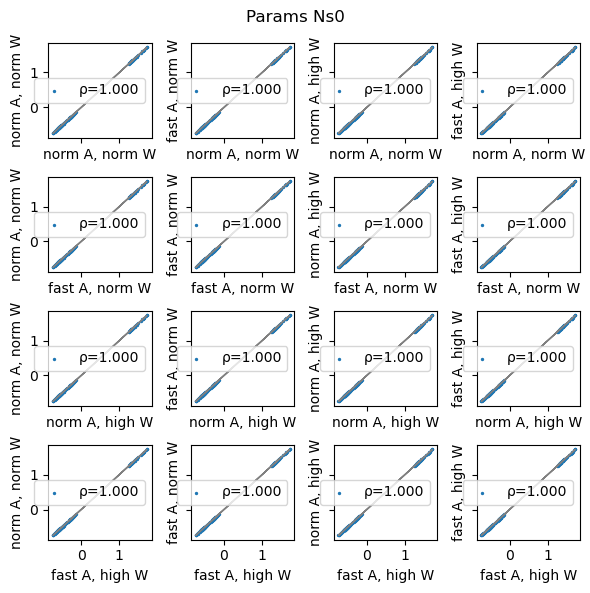

In [13]:
fig, axes = plt.subplots(n_paths, n_paths, sharex=True, sharey=True, figsize=(6,6))

for i in range(n_paths):
    for j in range(n_paths):
        ax = axes[i,j]
        x = params_paths_zerosum[i]["bias_Ns0"].view(-1)
        y = params_paths_zerosum[j]["bias_Ns0"].view(-1)
        rho = torch.corrcoef(torch.stack((x,y)))[0,1].item()
        ax.scatter(x, y, s=2, label=f'ρ={rho:.3f}')
        ax.legend()
        ax.plot(x, x, color='gray', lw=1)
        ax.set_xlabel(path_labels[i])
        ax.set_ylabel(path_labels[j])
fig.suptitle('Params Ns0')
fig.tight_layout()

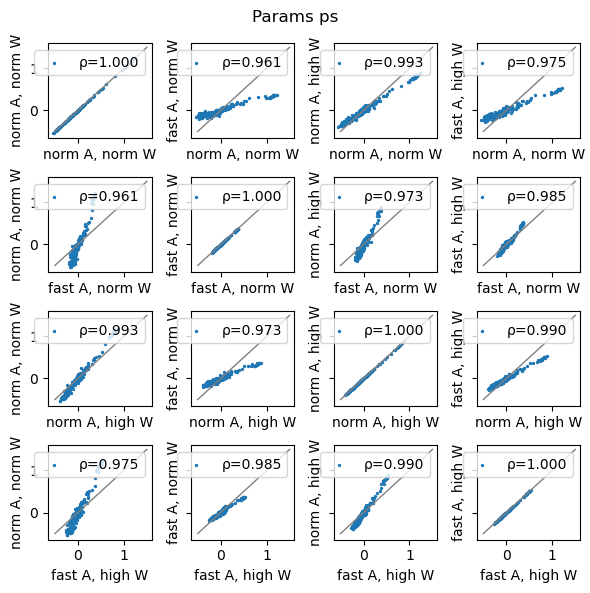

In [16]:
fig, axes = plt.subplots(n_paths, n_paths, sharex=True, sharey=True, figsize=(6,6))
lims = [-0.5,1.5]

for i in range(n_paths):
    for j in range(n_paths):
        ax = axes[i,j]
        x = params_paths_zerosum[i]["bias_ps"].view(-1)
        y = params_paths_zerosum[j]["bias_ps"].view(-1)
        rho = torch.corrcoef(torch.stack((x,y)))[0,1].item()
        ax.scatter(x, y, s=2, label=f'ρ={rho:.3f}')
        ax.legend()
        ax.plot(lims, lims, color='gray', lw=1)
        ax.set_xlabel(path_labels[i])
        ax.set_ylabel(path_labels[j])
fig.suptitle('Params ps')
fig.tight_layout()